In [19]:
import os
import numpy as np
import re
import pickle
import nltk
import pronouncing
from nltk.corpus import cmudict
from IPython.display import HTML
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation

A function from set 6 to parse the observations:

In [2]:
def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

In [3]:
def getRhyme(word, obs_map, reference):
    if word in reference.keys():
        rhymes = pronouncing.rhymes(word)
        # we can just take a set different here
        return sorted(list(set(rhymes) - (set(rhymes) - set(obs_map.keys()))))

In [4]:
def getStress(obs_map, reference):
    # go though all our words

    # if it's in references, get the last syllable with
    # an integer value at the end

    # if the integer > 0, then it is stressed, if not it
    # is unstressed
    stress = {}
    lastVow = {}
    count = 0
    # first lets go through all our words
    for key, value in obs_map.items():
        # now go through all the ones in our references
        if(key in reference.keys()):
            # if(len(reference[key]) > 1):
            # go through the possible pronounciations, from
            # the end, and get the last vowel

            diff = []
            for pronounce in reference[key]:
                # this is only a "vowel" if the last character
                # is an integer
                # now iterate backwards through the strings in
                # the pronounciation, and get the k
                for i in range(len(pronounce) - 1, -1, -1):
                    try:
                        # this will add the entire pronounciation
                        # and integer to our array
                        int(pronounce[i][-1])

                        # get rid of the -1 index if we want to look
                        # at the actual pronounciation

                        # if we need to, we can count syllables here as well
                        # just by adding a count, and commenting out the break
                        # count += 1

                        # there are acutally 2 types of stressed pronounciation
                        # here we don't care which one it is
                        diff.append(int(pronounce[i][-1]) % 2)
                        break
                    except ValueError:
                        continue
            lastVow[value] = diff
            # syllables will just have the random choice of our lastVow for now
            stress[value] = random.choice(diff)

        # if we don't know, we'll just set it to random for now
        else:
            count += 1
            lastVow[value] = [0, 1]
            stress[value] = random.choice([0, 1])
    # print(count)
    # print(len(obs_map))
    # print(lastVow[1], stress[1])
    # print(stress)
    
    return stress

In [5]:
def getSyllables(obs_map):
        file = open('Release/data/Syllable_dictionary.txt', 'r')

        syllable_dict = {}
        keys = obs_map.keys()
        # print(len(obs_map.keys()))
        # i = 0
        for line in file:
            l = line.strip().split()

            # all our words are saved to the observation dictionary with
            # special characters taken out, so we must use this regular
            # expression to strip out the special characters
            word = re.sub(r'[^\w]', '', l[0]).lower()
            if word in keys:
                l = sorted(l[1:])
                for i in range(len(l)):
                    try:
                        l[i] = int(l[i])
                    except ValueError:
                        continue
                syllable_dict[obs_map[word]] = l
                # print(word, l)
                # i += 1
            else:
                syllable_dict[obs_map[word]] = 100
        return syllable_dict

Helper functions for generating sentences:

In [6]:
def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def get_line(hmm, obs_map):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emissions, states = generate_emission_supervised(hmm, syllable_dict)
    print(len(emissions), len(states))
    sentences = []
    for emission in emissions:
        sentence = [obs_map_r[i] for i in emission]
        sentences += sentence
        sentences += ['1']

    return sentences 
    #' '.join(sentences).capitalize() 


First, load in the data and preprocess it. We want to create a dictionary for rhymes and a dictionary for which stress the word starts with.

In [7]:
text = open(os.path.join(os.getcwd(), \
                         'Release/data/shakespeare.txt')).read()
obs, obs_map = parse_observations(text)

In [8]:
reverse_obs_map = obs_map_reverser(obs_map)

Use the HMM class from the homework 6 solutions:

In [9]:
import random

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state. 

        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.

            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.

        Parameters:
            L:          Number of states.

            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Calculate initial prefixes and probabilities.
        for curr in range(self.L):
            probs[1][curr] = self.A_start[curr] * self.O[curr][x[0]]
            seqs[1][curr] = str(curr)

        # Calculate best prefixes and probabilities throughout sequence.
        for t in range(2, M + 1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                max_prob = float("-inf")
                max_prefix = ''

                # Iterate over all possible previous states to find one
                # that would maximize the probability of the current state.
                for prev in range(self.L):
                    curr_prob = probs[t - 1][prev] \
                                * self.A[prev][curr] \
                                * self.O[curr][x[t - 1]]

                    # Continually update max probability and prefix.
                    if curr_prob >= max_prob:
                        max_prob = curr_prob
                        max_prefix = seqs[t - 1][prev]

                # Store the max probability and prefix.
                probs[t][curr] = max_prob
                seqs[t][curr] = max_prefix + str(curr)

        # Find the index of the max probability of a sequence ending in x^M
        # and the corresponding output sequence.
        max_i = max(enumerate(probs[-1]), key=lambda x: x[1])[0]
        max_seq = seqs[-1][max_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            alphas:     Vector of alphas.

                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.

                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Note that alpha_j(0) is already correct for all j's.
        # Calculate alpha_j(1) for all j's.
        for curr in range(self.L):
            alphas[1][curr] = self.A_start[curr] * self.O[curr][x[0]]

        # Calculate alphas throughout sequence.
        for t in range(1, M):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible previous states to accumulate
                # the probabilities of all paths from the start state to
                # the current state.
                for prev in range(self.L):
                    prob += alphas[t][prev] \
                            * self.A[prev][curr] \
                            * self.O[curr][x[t]]

                # Store the accumulated probability.
                alphas[t + 1][curr] = prob

            if normalize:
                norm = sum(alphas[t + 1])
                for curr in range(self.L):
                    alphas[t + 1][curr] /= norm

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            betas:      Vector of betas.

                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.

                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize initial betas.
        for curr in range(self.L):
            betas[-1][curr] = 1

        # Calculate betas throughout sequence.
        for t in range(-1, -M - 1, -1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible next states to accumulate
                # the probabilities of all paths from the end state to
                # the current state.
                for nxt in range(self.L):
                    if t == -M:
                        prob += betas[t][nxt] \
                                * self.A_start[nxt] \
                                * self.O[nxt][x[t]]

                    else:
                        prob += betas[t][nxt] \
                                * self.A[curr][nxt] \
                                * self.O[nxt][x[t]]

                # Store the accumulated probability.
                betas[t - 1][curr] = prob

            if normalize:
                norm = sum(betas[t - 1])
                for curr in range(self.L):
                    betas[t - 1][curr] /= norm

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.

            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.

                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.

            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in range(1, N_iters + 1):
            if iteration % 10 == 0:
                print("Iteration: " + str(iteration))

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]
                    
                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]

                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 

        Arguments:
            M:          Length of the emission to generate.

        Returns:
            emission:   The randomly generated emission as a list.

            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(self.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.

    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.

        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrices A and O.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM


def unsupervised_HMM(X, n_states, N_iters):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.

    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.

        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    #D = len(observations)
    
    # Since we don't include the numbers of the poems anywhere 
    # in our observations but we do include them in obs_map, the
    # number of observations must be longer than than the length
    # of the set since the indices go past the length of the set
    D = max(observations) + 1

    # Randomly initialize and normalize matrices A and O.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM



We will train several naive HMMs. We will train on sequences that are lines, stanzas, and whole poems. We will also experiment with the number of hidden states for each of these. We will generate sequences and see which sequences look the best.

First, change the data to get it in forms of lines, stanzas, and whole poems:

In [10]:
lines = []
poems = []
stanzas = []
curr_poem = []
curr_stanza = []

# In a poem, there are 4 stanzas, with the 4th one only having 
# 2 lines
curr_line_stanza = 1
curr_line = 1

for element in obs:

    # If its not the poem number
    if curr_line != 1:
        lines.append(element)
        
    # Take care of appending the whole poem and the current 
    # stanza thats at the end of the poem
    if curr_line == 1 and curr_poem != []:
        poems.append(curr_poem)
        stanzas.append(curr_stanza)
        curr_poem = []
        curr_stanza = []
        curr_line_stanza = 0
        
    # This means we are at the very top
    elif curr_line == 1 and curr_poem == []:
        curr_line += 1
        continue
        
    else:
        for word in element:
            curr_poem.append(word)
            curr_stanza.append(word)
        if curr_line_stanza == 4:
            stanzas.append(curr_stanza)
            curr_stanza = []
            curr_line_stanza = 0
            
        if curr_line % 15 == 0:
            curr_line = 0
            
    curr_line_stanza += 1
    curr_line += 1

The last poem and last stanzas are not appended, so we will do this now:

In [11]:
last_poem = []
last_stanzas = []

for i in range(14):
    for element in obs[-(i + 1)]:
        last_poem.append(element)

poems.append(last_poem)

for i in range(0, 2):
    for element in obs[-(i + 1)]:
        last_stanzas.append(element)
        
stanzas.append(last_stanzas)

We will use hmm's with 1, 2, 4, 8, 16, and 32 states for the lines, poems, and stanzas.

In [12]:
line_hmms = []
poem_hmms = []
stanza_hmms = []

In [13]:
states = [1, 2, 4, 8, 16, 32]

for element in states:
    hmm = unsupervised_HMM(lines, element, 100)
    line_hmms.append(hmm)
    print("an hmm is trained!")
    
for element in states:
    hmm = unsupervised_HMM(poems, element, 100)
    poem_hmms.append(hmm)
    print("an hmm is trained!")

for element in states:
    hmm = unsupervised_HMM(stanzas, element, 100)
    stanza_hmms.append(hmm)
    print("an hmm is trained!")
    

Iteration: 10


KeyboardInterrupt: 

Pickle the models so that we dont have to rerun them:

In [33]:
pickle.dump( [line_hmms, poem_hmms, stanza_hmms], open( "NaiveHMMs.p", "wb" ) )

A function to generate a Shakespearean sonnet from the naive HMM. Since each word must be at least one syllable, and most words aren't greater than 3 syllables, we will generate a random number between 5 and 9, and this will determine the number of words in a particular line:

In [61]:
def generateNaiveSonnet(hmm):
    numwords = 0
    lineLengths = []
    
    # Decide on lengths for each line
    for i in range(14):
        temp = random.randint(5, 9)
        lineLengths.append(temp)
        numwords += temp
    
    # Sample and convert sentence.
    emission, states = hmm.generate_emission(numwords)
    sentence = [reverse_obs_map[i] for i in emission]
    
    # We trained in reverse, so lets reverse the poem
    sentence = sentence[::-1]

    # Split into lines
    lines = []
    prev = 0
    for i in range(len(lineLengths)):
        lines.append(sentence[prev:prev + lineLengths[i]])
        prev = lineLengths[i]
         
    #print each line
    for line in lines:
        print(' '.join(line).capitalize())

Load HMMs trained on reversed sequences.

In [13]:
naive_HMMs_reverse = pickle.load( open( "NaiveHMMsReverse.p", "rb" ) )

In [88]:
generateNaiveSonnet(naive_HMMs_reverse[0][5])

When robbed nor twixt do to
Lend and his this action
To lend and his this action
Lend and his this action
To lend and his this action this for she
This action this for she well i this hell
This action this for she well i this hell
This action this for she
To lend and his this action
Lend and his this action this for she well
This action this for she well
Lend and his this action this for she
His this action this for she well
And his this action this for


Below is a function which takes in a trained hmm and adjusts the observation and transition matrices to incorportate meter. To do this, we split each state into four states. Keep in mind that we are reversing the order of the sequence to help with rhyme. Now, one state corresponds to words ending in stressed syllables that are odd in length, one corresponds to words ending in stressed syllables that are even in length, and the same for unstressed cases. 

In [26]:
def addMeter(hmm, obs_map, syllables, stresses):
    A_meter = []
    O_meter = []
    
    # Redo the transition matrix. Each row in A 
    # corresponds to the probability of transitioning
    # from the state corresponding to that row 
    # A_meter will have 4 times as many rows and columns as 
    # A
    for row in hmm.A: 
        
        # state1 will be the unstressed state/odd length
        # state2 will be unstressed state/even length
        # state3 will be stressed state/odd length
        # state4 will be stressed state/even length
        state1 = []
        state2 = []
        state3 = []
        state4 = []
        
        # Each state can transition to two other states, so
        # We will divide the probability in half so that there
        # is an equal likelihood of going to either stressed 
        # state
        for entry in row:
            new_prob = entry / 2.
            
            # State 1 can go to states 3 and 4
            state1.append(0)
            state1.append(0)
            state1.append(new_prob)
            state1.append(new_prob)
            
            # State 2 can go to states 1 and 2
            state2.append(new_prob)
            state2.append(new_prob)
            state2.append(0)
            state2.append(0)
            
            # State 3 can go to states 1 and 2
            state3.append(new_prob)
            state3.append(new_prob)
            state3.append(0)
            state3.append(0)  
            
            # State 4 can go to states 3 and 4
            state4.append(0)
            state4.append(0)
            state4.append(new_prob)
            state4.append(new_prob)
            
        A_meter.append(state1)
        A_meter.append(state2)
        A_meter.append(state3)
        A_meter.append(state4)
        
    # Now, we do the O matrix. Each row represents a 
    # state and each column represents a probability of
    # emitting a particular observation. For a particular 
    # observation, it'll have a nonzero probability in 
    # the state its supposed to be in and a zero probability 
    # in other states.
    for row in hmm.O:
        
        state1 = []
        state2 = []
        state3 = []
        state4 = []
        
        # We are expecting that all words are in stressed_dict
        # in the form of integers indexed starting at 1 
        for i in range(len(row)):
            
            # Determine whether the syllable count is odd or even
            odd = syllables[i][0] % 2
            if syllables[i][0] == -1:
                odd = -1
            
            # Determine whether the last syllable is stressed or not
            stress = stresses[i]
            
            # If the word is one of the poem numbers
            if odd == -1:
                state1.append(0)
                state2.append(0)
                state3.append(0)
                state4.append(0)
                
            # if the word ends in an unstressed syllable and 
            # is odd in length
            elif stress == 0 and odd == 1:
                state1.append(row[i])
                state2.append(0)
                state3.append(0)
                state4.append(0)
                
            # if the word ends in an unstressed syllable and is 
            # even in length 
            elif stress == 0 and odd == 0:
                state1.append(0)
                state2.append(row[i])
                state3.append(0)
                state4.append(0)
                
            # if the word ends in a stressed syllable and is odd
            # in length 
            elif stress == 1 and odd == 1:
                state1.append(0)
                state2.append(0)
                state3.append(row[i])
                state4.append(0)
                
            # if the word ends in a stressed syllable and is even
            # in length
            else:
                state1.append(0)
                state2.append(0)
                state3.append(0)
                state4.append(row[i])
                
        O_meter.append(state1)
        O_meter.append(state2)
        O_meter.append(state3)
        O_meter.append(state4)
        
    # Normalize each row so that the sum of the rows is 1
    A_meter2 = []
    O_meter2 = []
    for i in range(len(A_meter)):
        A_meter2.append(np.array(A_meter[i]) / np.array(A_meter[i]).sum())
        O_meter2.append(np.array(O_meter[i]) / np.array(O_meter[i]).sum())
    
    return np.array(A_meter2), np.array(O_meter2)

In [28]:
reference = cmudict.dict()

syllable_dict = getSyllables(obs_map)
stress_dict = getStress(obs_map, reference)

for i in range(154):
    syllable_dict[obs_map[str(i + 1)]] = [-1]

Reverse all the data and then train HMMs:

In [153]:
lines_reverse = []
poems_reverse = []
stanzas_reverse = []

for element in lines:
    lines_reverse.append(element[::-1])
    
for element in poems:
    poems_reverse.append(element[::-1])
    
for element in stanzas:
    stanzas_reverse.append(element[::-1])

In [16]:
line_hmms_reverse = []
poem_hmms_reverse = []
stanza_hmms_reverse = []
states = [1, 2, 4, 8, 16, 32]

for element in states:
    hmm = unsupervised_HMM(lines_reverse, element, 100)
    line_hmms_reverse.append(hmm)
    print("an hmm is trained!")
    
for element in states:
    hmm = unsupervised_HMM(poems_reverse, element, 100)
    poem_hmms_reverse.append(hmm)
    print("an hmm is trained!")

for element in states:
    hmm = unsupervised_HMM(stanzas_reverse, element, 100)
    stanza_hmms_reverse.append(hmm)
    print("an hmm is trained!")

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
an hmm is trained!
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
an hmm is trained!
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
an hmm is trained!
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
an hmm is trained!
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
an hmm is trained!
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
an hmm is trained!
Iteration: 10
Iteration: 20
Iteration: 3

Pickle reversed data:

In [17]:
pickle.dump( [line_hmms_reverse, poem_hmms_reverse, stanza_hmms_reverse], \
            open( "NaiveHMMsReverse.p", "wb" ) )

Load the HMMs from the pickled files:

In [53]:
naive_HMMs = pickle.load( open( "NaiveHMMs.p", "rb" ) )
naive_HMMs_reverse = pickle.load( open( "NaiveHMMsReverse.p", "rb" ) )

Try using the addMeter function on an HMM to test that it works:

In [149]:
naive_HMMs_reverse = pickle.load( open( "NaiveHMMsReverse.p", "rb" ) )
sample_HMM = naive_HMMs_reverse[2][5]
new_A, new_O = addMeter(sample_HMM, obs_map, syllable_dict, stress_dict)
sample_HMM.A = new_A
sample_HMM.O = new_O
sample_HMM.L = len(new_A)
sample = get_line(sample_HMM, obs_map)

array = sample[::-1]
 


new_string = ""
for element in array:
    if element == '1':
        print(new_string)
        print("")
        new_string = ""
    else:
        new_string += element 
        new_string += " "
print(new_string)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14 85


reproving act divert canopy woos 

sunset clear being never dwell unused at 

illused ist worst for my dateless refuse 

for may among reserve offenders that 

policy action me messengers four 

love th spirit vainly deformedst kindness less love 

power nothing should ruining held before 

miscalled above profaned rarities of 

burthens uphold churls natures great shadow 

or your travail wherein beautys duty 

words for called consent delights tomorrow 

quill his to despise appetite beauty 

by profaned predict befits against peace 

tired thou persuade perspective but increase 


generate emission with meter, rhyme, and 10 syllables per line:

In [141]:
def generate_emission_supervised(hmm, syllables):
    '''
    Generates an emission of length M, assuming that the starting state
    is chosen uniformly at random. 

    Arguments:
        M:          Length of the emission to generate.

    Returns:
        emission:   The randomly generated emission as a list.

        states:     The randomly generated states as a list.
    '''

    
    emissions = []
    state = random.choice(range(hmm.L))
    states = []
    first_rhymes = [0, 2, 3, 6, 7, 10, 11]
    rhyme_words = []
    
    # Make sure the start state is stressed (states 3 or 4) 
    while (state % 3 != 2 or state % 4 != 3):
        state = random.choice(range(hmm.L))

    for i in range(14):
        
        # Keep a count of the current number of syllables for a line
        count_syllables = 0
        
        emission = []
        
        while count_syllables < 10:

            # Append state.
            states.append(state)
            num_loops = 0
            
            while True:
                # Sample next observation.
                rand_var = random.uniform(0, 1)
                next_obs = 0

                while rand_var > 0:
                    rand_var -= hmm.O[state][next_obs]
                    next_obs += 1

                next_obs -= 1
                if syllables[next_obs][0] + count_syllables <= 10:

                    if count_syllables == 0 and i in first_rhymes:
                        rhymes = getRhyme(reverse_obs_map[next_obs], obs_map, reference)
                        if rhymes == None or len(rhymes) == 0:
                            continue
                        rhyme_words.append(rhymes)
                    elif count_syllables == 0 and i not in first_rhymes:
                        
                        if i == 1:
                            possible_words = rhyme_words[0]
                               
                        if i == 4:
                            possible_words = rhyme_words[1]
                        if i == 5:
                            possible_words = rhyme_words[2]
                        if i == 8:
                            possible_words = rhyme_words[3]
                        if i == 9:
                            possible_words = rhyme_words[4]
                        if i == 12:
                            possible_words = rhyme_words[5]
                        if i == 13:
                            possible_words = rhyme_words[6]
                        
                        next_obs = obs_map[random.choice(possible_words)]
                        
                    count_syllables += syllables[next_obs][0]
                    emission.append(next_obs)
                    # Sample next state.
                    rand_var = random.uniform(0, 1)
                    next_state = 0
                    #print("not in infinite loop")
                    break
                    
                if num_loops > 100:
                    
                    rand_var = random.uniform(0, 1)
                    next_state = 0
                    while rand_var > 0:
                        rand_var -= hmm.A[state][next_state]
                        next_state += 1

                    next_state -= 1
                    state = next_state
                    num_loops = 0
                
                num_loops += 1

            
            while rand_var > 0:
                rand_var -= hmm.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state
        emissions.append(emission)
        print(i)

    return emissions, states

Train for more states:

In [ ]:
line_hmms_reverse_high = []
poem_hmms_reverse_high = []
stanza_hmms_reverse_high = []
states = [64]


line_hmms_reverse_high.append(hmm)
    
for element in states:
    hmm = unsupervised_HMM(poems_reverse, element, 100)
    poem_hmms_reverse_high.append(hmm)
    print("an hmm is trained!")

for element in states:
    hmm = unsupervised_HMM(stanzas_reverse, element, 100)
    stanza_hmms_reverse_high.append(hmm)
    print("an hmm is trained!")

Iteration: 10


In [ ]:
pickle.dump( [line_hmms_reverse_high, poem_hmms_reverse_high, \
              stanza_hmms_reverse_high], open( "NaiveHMMsReverseHigh.p", "wb" ) )

### Visualizations:

The following code is used for visualization of states. We use the word cloud diagrams from set 6:

In [23]:
def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds

Generate a wordcloud for a 4 state HMM:

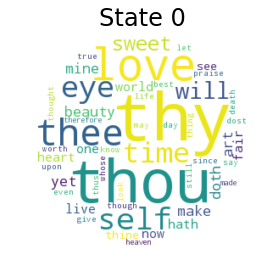

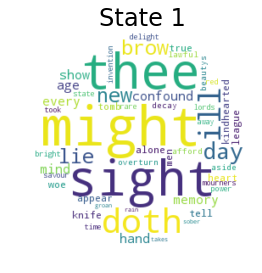

In [30]:
wordclouds = states_to_wordclouds(naive_HMMs_reverse[0][1], obs_map)

Now, change this HMM to be semi-supervised using our addMeter function and show the word clouds for the states:

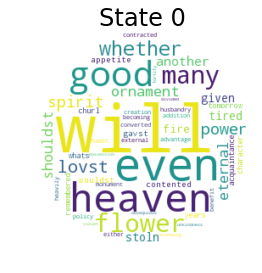

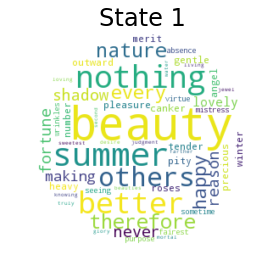

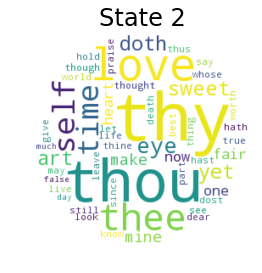

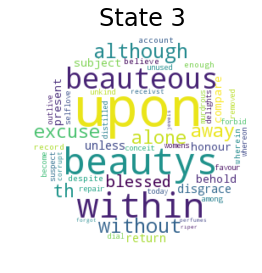

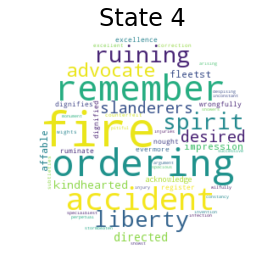

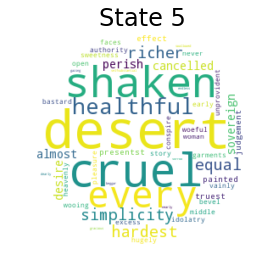

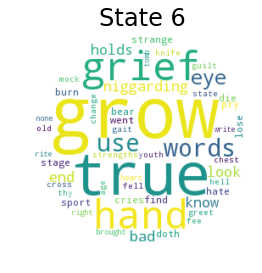

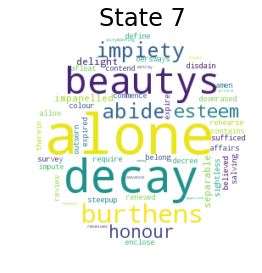

In [31]:
sample_HMM = naive_HMMs_reverse[0][1]
new_A, new_O = addMeter(sample_HMM, obs_map, syllable_dict, stress_dict)
sample_HMM.A = new_A
sample_HMM.O = new_O
sample_HMM.L = len(new_A)
wordclouds = states_to_wordclouds(sample_HMM, obs_map)

In [32]:
naive_HMMs_reverse[0][1].A

array([[ 0.        ,  0.        ,  0.49888811,  0.49888811,  0.        ,
         0.        ,  0.00111189,  0.00111189],
       [ 0.49888811,  0.49888811,  0.        ,  0.        ,  0.00111189,
         0.00111189,  0.        ,  0.        ],
       [ 0.49888811,  0.49888811,  0.        ,  0.        ,  0.00111189,
         0.00111189,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.49888811,  0.49888811,  0.        ,
         0.        ,  0.00111189,  0.00111189],
       [ 0.        ,  0.        ,  0.25699059,  0.25699059,  0.        ,
         0.        ,  0.24300941,  0.24300941],
       [ 0.25699059,  0.25699059,  0.        ,  0.        ,  0.24300941,
         0.24300941,  0.        ,  0.        ],
       [ 0.25699059,  0.25699059,  0.        ,  0.        ,  0.24300941,
         0.24300941,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.25699059,  0.25699059,  0.        ,
         0.        ,  0.24300941,  0.24300941]])